In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/IA2_proyecto/data/PlantVillage'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/43fd6ace-3712-494a-9aba-de5482d22561___RS_HL 1968.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/04481ca2-f94c-457e-b785-1ac05800b7ec___RS_HL 1930.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/414f6249-9f78-4af5-9593-9d5a7e7d979f___RS_HL 1918.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/3edf7c3f-73e0-439c-870d-76cfd7c3bc45___RS_HL 1859.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/1a1184f8-c414-4ead-a4c4-41ae78e29a82___RS_HL 1971.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/2d98cbc8-cbe6-423c-b2ab-3f7f8bcea5d5___RS_HL 1945.JPG
/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage/Potato___healthy/30126310-39de-4c02-b10a-23409417a4f6___RS_HL 1826.JPG
/content/drive/MyDrive/IA2_proyect

In [ ]:
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ignore the warnings
import warnings
warnings.filterwarnings('ignore')

# DL Libraries

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# Other libraries
import os
import random
import logging


# Set TensorFlow logging level to error
tf.get_logger().setLevel(logging.ERROR)

In [ ]:
import tensorflow as tf
tf.config.optimizer.set_jit(False)  # Disable XLA

In [ ]:
import os

data_dir = '/content/drive/MyDrive/IA2_proyecto/data/PlantVillage/PlantVillage'
test_dir = '/content/drive/MyDrive/IA2_proyecto/data/PotatoPlants'

# Check if the directories exist
print("Training directory exists:", os.path.exists(data_dir))
print("Testing directory exists:", os.path.exists(test_dir))


Training directory exists: True
Testing directory exists: True


In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of training data for validation
)


test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Validation data generator (only rescaling, no augmentation)
valid_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

In [ ]:
# Load training data and split it into training and validation sets
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Set as training data
)

# Load validation data
validation_generator = valid_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Set as validation data
)

Found 1722 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [ ]:
# Load test data
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2152 images belonging to 3 classes.


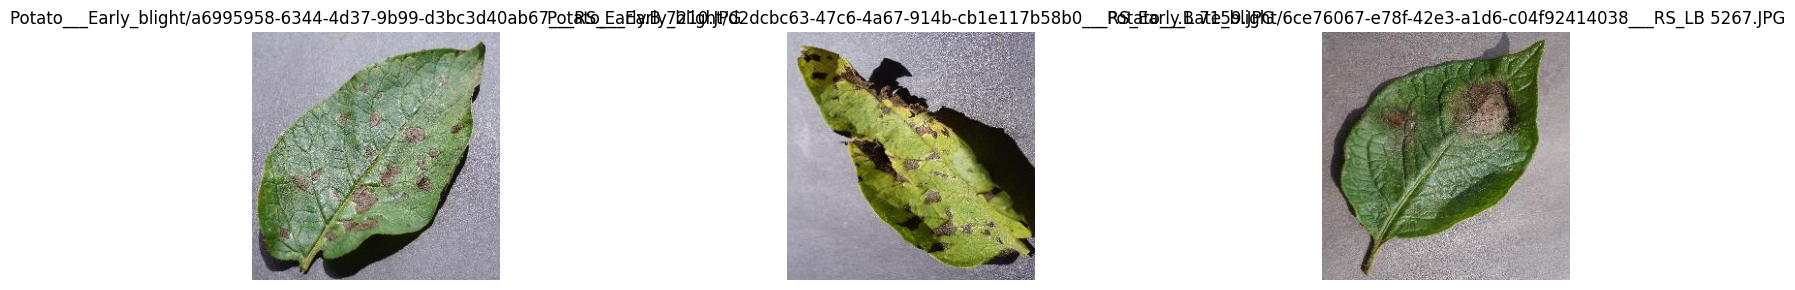

In [ ]:
# Creating a function to visualize the images

# Function to select and display random images
def display_random_images(generator, num_images):
    # Get list of all filenames in the generator
    image_filenames = generator.filenames

    # Select random images
    selected_images = random.sample(image_filenames, min(num_images, len(image_filenames)))

    # Create a figure and axes
    fig, axes = plt.subplots(1, num_images, figsize=(18, 3), facecolor='white')

    # Display each image
    for i, image_filename in enumerate(selected_images):
        # Load image
        image_path = os.path.join(generator.directory, image_filename)
        image = plt.imread(image_path)

        # Display image
        axes[i].imshow(image)
        axes[i].axis('off')
        axes[i].set_title(image_filename)  # Set image filename as title

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# Display 5 random images from the training set
display_random_images(train_generator,3)

In [ ]:
# Extracting the class labels
classes = train_generator.class_indices
print(f'Class labels: {classes}')

Class labels: {'Potato___Early_blight': 0, 'Potato___Late_blight': 1, 'Potato___healthy': 2}


# **IMPORT PRETRAIED MODEL**

In [ ]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(224,224,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.trainable = False

In [ ]:
# # Summary of the pretrained model
#conv_base.summary()

In [ ]:
# Define the CNN model
model = Sequential()

model.add(conv_base)
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(264, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())

# Dense layer with 64 units
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())

# Dense layer with 4 units (output layer)
# Input size: 64, Output size: 4
model.add(Dense(3, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 264)            │     6,623,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 264)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 264)            │         1,056 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,358,699 (81.48 MB)

 Trainable params: 6,642,331 (25.34 MB)

 Non-trainable params: 14,716,368 (56.14 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
  )

In [ ]:
# Train the model
history = model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 633s 12s/step - accuracy: 0.4340 - loss: 1.3227 - val_accuracy: 0.5093 - val_loss: 0.9988
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 80s 533ms/step - accuracy: 0.5883 - loss: 1.0184 - val_accuracy: 0.6512 - val_loss: 0.7629
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.6396 - loss: 0.8147 - val_accuracy: 0.8256 - val_loss: 0.5672
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 534ms/step - accuracy: 0.6906 - loss: 0.7381 - val_accuracy: 0.9047 - val_loss: 0.4323
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 536ms/step - accuracy: 0.7201 - loss: 0.6646 - val_accuracy: 0.9209 - val_loss: 0.3539
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 535ms/step - accuracy: 0.7589 - loss: 0.5819 - val_accuracy: 0.9372 - val_loss: 0.3116
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 533ms/step - accuracy: 0.7724 - loss: 0.5570 - val_accuracy: 0.9419 - val_loss: 0.2773
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 29s 535ms/step - accuracy: 0.8005 - loss: 0.4744 - val_accur

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print('Test accuracy:', accuracy)


14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step - accuracy: 0.9605 - loss: 0.1241
Test accuracy: 0.9511628150939941


In [ ]:
pred = model.predict(validation_generator)

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 245ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


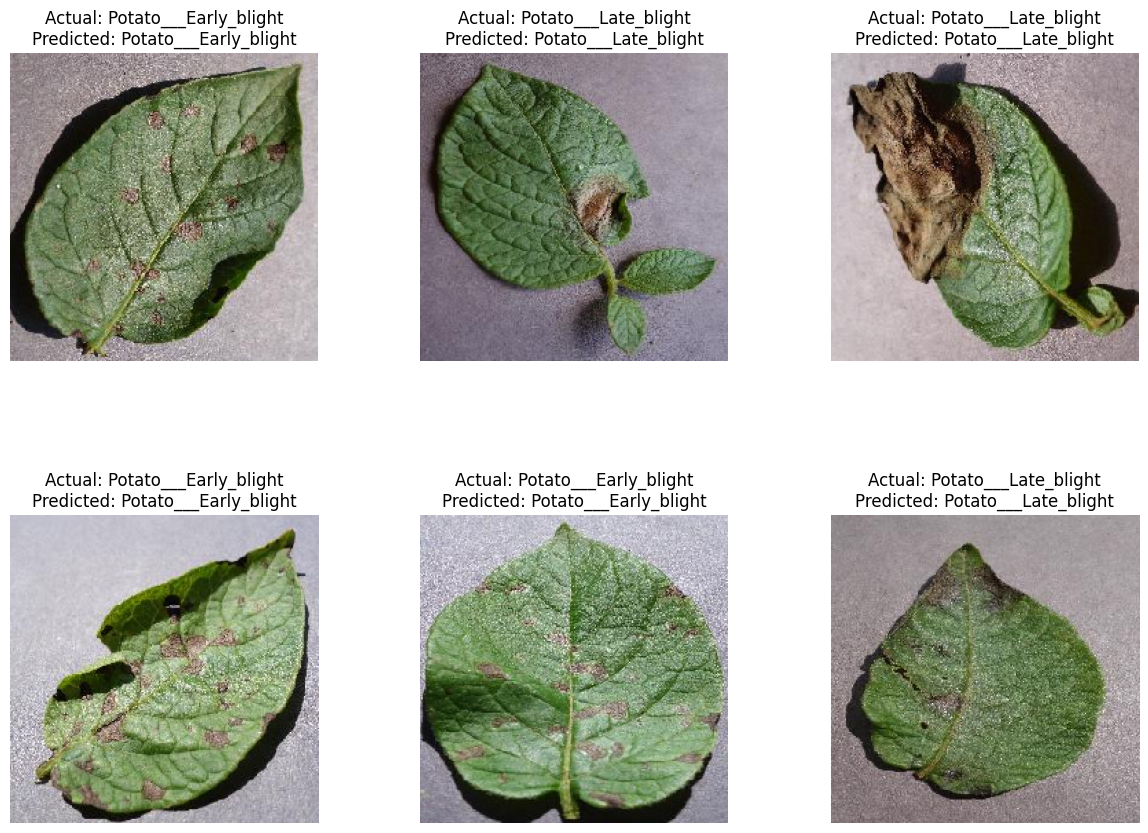

In [ ]:
# Set number of images to display
num_images_to_display = 12

# Get the class names from the generator
classes = list(train_generator.class_indices.keys())

# Plot the images with their actual and predicted labels
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    if i < num_images_to_display:
        # Extract image and label
        img, label = validation_generator[i]

        # img has shape (batch_size, height, width, channels); select the first image in the batch
        image = img[0]

        # Display the image
        ax.imshow(image)

        # Get actual and predicted labels
        actual_label = classes[np.argmax(label[0])]
        predicted_label = classes[np.argmax(model.predict(np.expand_dims(image, axis=0)))]

        # Set title with actual and predicted labels
        ax.set_title(f"Actual: {actual_label}\nPredicted: {predicted_label}")
        ax.axis('off')


# **Plotting the Graph**

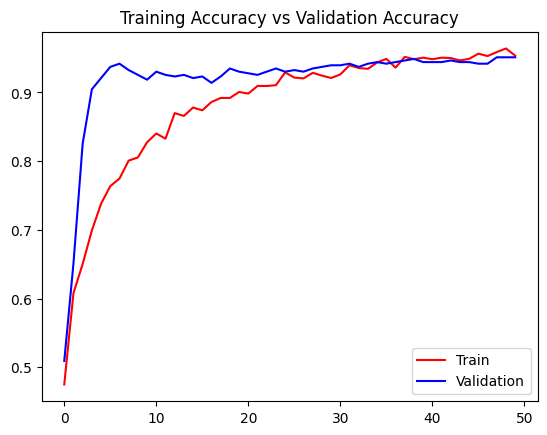

In [ ]:
# Plotting the graph of Accuracy and Validation Accuracy
plt.title('Training Accuracy vs Validation Accuracy')

plt.plot(history.history['accuracy'], color='red',label='Train')
plt.plot(history.history['val_accuracy'], color='blue',label='Validation')

plt.legend()


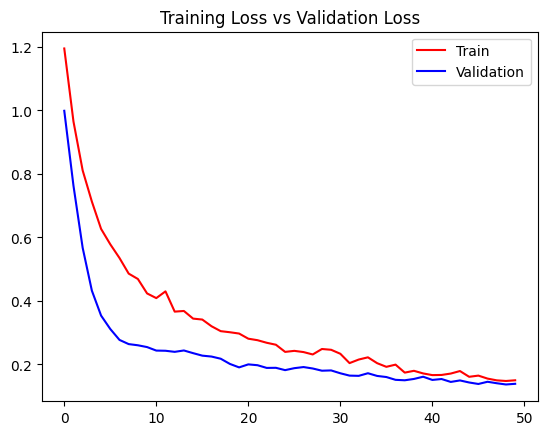

In [ ]:
# Plotting the graph of Accuracy and Validation loss
plt.title('Training Loss vs Validation Loss')

plt.plot(history.history['loss'], color='red',label='Train')
plt.plot(history.history['val_loss'], color='blue',label='Validation')

plt.legend()